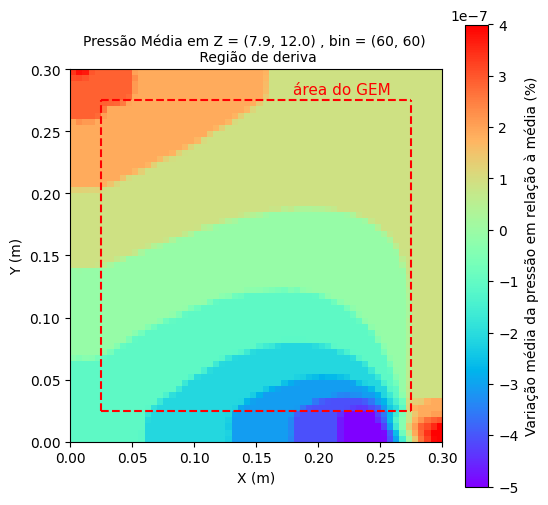

In [221]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm



# Ler os dados do arquivo CSV
file_path = r"C:\Users\Daniel\Documents\ansys data\streamlines_gem_padrao\sol_gem_standard_laminar.txt"  # Caminho para o arquivo de dados
df = pd.read_csv(file_path,delimiter = ",")
df.columns = df.columns.str.strip()

# Definir os limites do intervalo de z (opcional)
zmin = 7.9
zmax = 12

zmin = zmin*1e-3
zmax = zmax*1e-3

#regiao = "GEM3 - Anodo"
df_filtered = df[(df['z-coordinate'] >= zmin) & (df['z-coordinate'] <= zmax)]

# Definir o tamanho da grade 2D
num_bins = 60

# Criar a matriz do histograma 2D
heatmap, xedges, yedges = np.histogram2d(df_filtered['x-coordinate'],
                                         df_filtered['y-coordinate'],
                                         bins=num_bins,
                                         weights=df_filtered['absolute-pressure'],
                                         range=[[0,0.3],[0,0.3]])

counts, _, _ = np.histogram2d(df_filtered['x-coordinate'], df_filtered['y-coordinate'], bins=num_bins,range=[[0,0.3],[0,0.3]])

# Calcular a pressão média em cada bin (evitar divisão por zero)
mean_pressure = np.divide(heatmap, counts, where=counts!=0)

media = np.mean(mean_pressure)

mean_pressure = 100 - mean_pressure*100/media


# Plotar o histograma 2D
plt.figure(figsize=(6, 6))
plt.imshow(mean_pressure.T, origin='lower', cmap='rainbow', extent=(0, 0.3, 0, 0.3), vmin = -5e-7, vmax = 4e-7)
plt.colorbar(label='Variação média da pressão em relação à média (%)')
plt.title(f'Pressão Média em Z = {zmin*1000,zmax*1000} , bin = {num_bins,num_bins} \n Região de deriva',fontsize = 10)
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.gca().set_aspect('equal', adjustable='box')
plt.hlines(0.025, 0.025,0.275, linestyles='dashed', colors='red')
plt.hlines(0.275, 0.025,0.275, linestyles='dashed', colors='red')
plt.vlines(0.275, 0.025,0.275, linestyles='dashed', colors='red')
plt.vlines(0.025, 0.025,0.275, linestyles='dashed', colors='red')
plt.text(0.18,0.28, "área do GEM", color="red",fontsize = 11)
#plt.savefig("/content/" + regiao + ".png")
plt.show()


In [223]:
import numpy as np
import pandas as pd
import scipy.interpolate as interp
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from concurrent.futures import ProcessPoolExecutor
import pickle
import ipywidgets as widgets



def load_data(filename : str, num_seed : float , maxoumin : str):
    # Carregar o arquivo CSV e remover os espaços do cabeçalho
    arq = np.genfromtxt(filename, delimiter=',', skip_header=1)  # Lê o arquivo ignorando a primeira linha (cabeçalho)

    mask_non_zero_velocities = np.all(arq[:, 5:7] != 0, axis=1)
    arq = arq[mask_non_zero_velocities] 

    # Dividir os dados nas colunas: x, y, z e as velocidades (vx, vy, vz)
    data = arq[:, [1, 2, 3, 5, 6, 7]]

 
    # Filtrando as sementes, onde 'x-coordinate' é maior que num_seed vezes o valor máximo de 'x-coordinate'
    max_x = np.max(arq[:, 1])  # Máximo da coluna de 'x-coordinate'
    min_x = np.min(arq[:,1])
    dic = {"max" : arq[arq[:, 1] >= max_x * num_seed, 1:4] , "min" : arq[arq[:, 1] <= min_x * num_seed, 1:4] }
    seeds = dic[maxoumin]  # Selecionando as colunas de 'x-coordinate', 'y-coordinate', 'z-coordinate'

    return seeds, data, min_x

def create_interpolator(data):
    #vou criar o interpolador pra ter o valor da velocidade em qualquer ponto
    pontos = data[:,:3]
    velocidades = data[:,3:]
    #retornar a função do interpolador para acessar dado pontos qualquer x0,y0,z0
    return interp.NearestNDInterpolator(pontos, velocidades)


def streamline(interpolator, seeds , t_max : float, dt : float, direction : int, coord_lim : str, value_lim : float):
    coord = { "x" : 0, "y": 1, "z" : 2}


    def velocity(t, y): #função que serve de input para o integrador RK4
      v = interpolator(y)
      return v 
    
    def event(t, y):
        # Aqui 'y[0]' é a coordenada x, 'y[1]' é y e 'y[2]' é z (assumindo que são 3D)
        return  value_lim - y[coord[coord_lim]]   # Retorna a diferença entre x e Xf (se x > Xf, evento será disparado)

    # Definir que o evento deve ser disparado quando x > Xf
    event.terminal = True  # Indica que a integração deve ser interrompida
    event.direction = direction

    sol = [integrate.solve_ivp(velocity, [0, t_max], seed, t_eval=np.arange(0, t_max, dt), method = "RK45",events = event).y for seed in seeds]
    
    return sol



def recreate_vel_field(interpolator, streamlines):
    contador = len(streamlines)
    i = 0
    
    # Inicializa os arrays como ndarrays com o tamanho apropriado
    list_streamline = np.empty((contador, ), dtype=object)  # Armazenar as streamlines
    list_modv = np.empty((contador, ), dtype=object)         # Para armazenar os módulos das velocidades
    list_medias = np.zeros(contador)                         # Para armazenar as médias
    
    for idx, streamline in enumerate(streamlines):
        modv = []
        for pontos in streamline.T:
            modv.append(np.linalg.norm(interpolator(pontos), axis=1))
        
        list_modv[idx] = np.array(modv)  
        list_medias[idx] = np.mean(list_modv[idx]) 
        
        i += 1
        print(f"loading... {100 * i // contador}%")

    return list_medias,list_modv


def RTD(streamlines, modv, unidade: str,bins : int,intervalo : tuple):
    #tempo de residencia é o o tamanho da streamline dividido pela velociade média
    # (M,N,3)
    tempos = []
    divisor = { "s" : 1, "min" : 60}
    #calcular o tamanho da streamline com um integrador
    for streamline, v in zip(streamlines,modv):
      diff = np.diff(np.array(streamline).T,axis=0)
      distancia = np.linalg.norm(diff,axis=1)
      comprimento = np.sum(distancia)
      tempos.append((comprimento/v)/divisor[unidade])
    plt.figure()
    plt.hist(tempos,bins, range = intervalo)
    plt.xlabel(f'tempos de residência ({unidade})')
    plt.ylabel("contagens")
    plt.show()
    return tempos


def plot_streamlines(streamlines, timeresidence, vmin: float, vmax : float,elev: float ,azim : float,t_interval : tuple):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=elev, azim=azim)
    # Selecionar o colormap
    cmap = plt.get_cmap("rainbow")

    # Definir o intervalo de 0 a 30

    timeresidence =  np.array(timeresidence)

    mask = ((timeresidence >= t_interval[0]) & (timeresidence <= t_interval[1]))

    streamlines_filtradas = [streamlines[i] for i in range(len(streamlines)) if mask[i]]
    tempos_filtrados = timeresidence[mask]

    cores = cmap((tempos_filtrados - vmin) / (vmax - vmin))

    # Criar o gráfico de dispersão
    for i in range(len(streamlines_filtradas)):
        ax.plot(streamlines_filtradas[i][0],  # x
                streamlines_filtradas[i][1],  # y
                streamlines_filtradas[i][2], #z
                color=cores[i],  # Aplica a cor para cada streamline
                lw=0.5)  # Linha com maior espessura

    # Adicionar barra de cores para mapear os tempos
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])  # Não precisamos de dados extras aqui
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical')
    cbar.set_label('Tempo (min)')

    ax.set_zlim(0,0.06)
    # Títulos e rótulos
    ax.set_title('Streamlines coloridas por tempo de residência')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

def plot_velocidades(streamlines, velocidades, vmin : float, vmax : float ,elev : float ,azim : float, samples : int, tamanho : float):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=elev, azim=azim)
    # Selecionar o colormap
    
    cmap = plt.get_cmap("rainbow")

    for streamline,vel in zip(streamlines,velocidades):
        vel = np.array(vel)*100

        indices = np.random.choice(len(streamline[0]), size=samples, replace=False) #criando escolhas aleatórias baseadas no tamanho do x da streamline

        cores = cmap((vel - vmin) / (vmax - vmin)) #ajustar o colormap

        ax.scatter(streamline[0,indices], #x
                   streamline[1,indices], #y
                   streamline[2,indices], #z
                   c= cores[indices],
                   s = tamanho)

    # Adicionar barra de cores para mapear os tempos
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])  # Não precisamos de dados extras aqui
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical')
    cbar.set_label('velocidade (cm/s)')

    ax.set_zlim(0,0.03)
    # Títulos e rótulos
    ax.set_title('Streamlines coloridas por módulo da velocidade')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()


def plot_dimensoes(data):
    plt.figure(figsize=(8,8))
    plt.scatter(data[:,0],data[:,1],s=0.5)
    plt.xlabel("X(m)")
    plt.ylabel("Y(m)")
    plt.show()

def plot_seeds(seeds, s: int):
    plt.figure(figsize=(8,8))
    plt.scatter(seeds.T[1],seeds.T[2],s)
    plt.xlabel("Y (m)")
    plt.ylabel("Z (m)")
    plt.title(f"Pontos iniciais = {len(seeds)}")
    plt.show()  
    

In [225]:

#seeds,df,Xf = load_data(r"C:\Users\Daniel\Documents\ansys data\streamlines_camara\camara_degradacao_transiente_laminar_nodes.txt",0.997,"min")
seeds,df,_ = load_data(r"C:\Users\Daniel\Documents\ansys data\streamlines_gem_padrao\sol_gem_standard_laminar.txt",0.995,"max")
#seeds,df,_ = load_data(r"C:\Users\Daniel\Documents\ansys data\streamlines_gem_modified\sol_gem_modified_nodes.txt",0.995,"max")

In [224]:
plot_dimensoes(df)

InvalidIndexError: (slice(None, None, None), 0)

<Figure size 800x800 with 0 Axes>

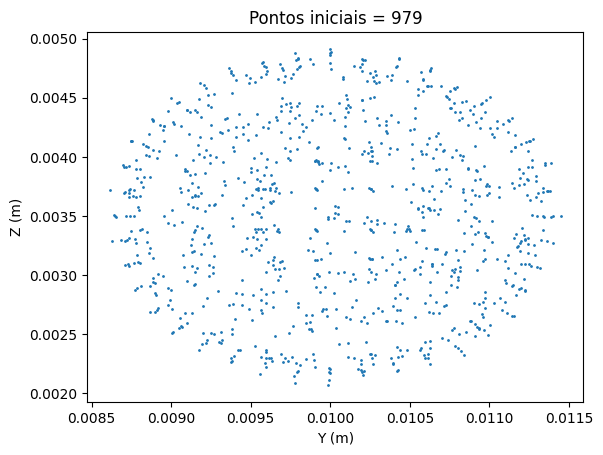

In [128]:
plot_seeds(seeds,1)

In [54]:
interpolator = create_interpolator(df)

In [55]:
streamlines = streamline(interpolator,seeds,t_max=3800,dt=0.5,direction= -1,coord_lim= "y",value_lim= 0.34)

In [ ]:
medias,modv = recreate_vel_field(interpolator, streamlines)


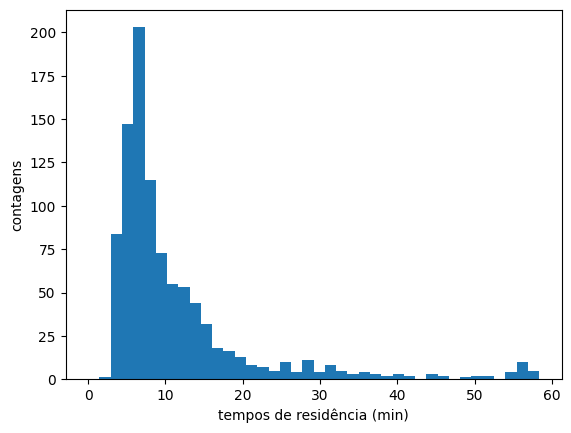

In [11]:
timeresidence = RTD(streamlines,medias,bins = 40, intervalo = (0,3500/60),unidade = "min")

In [130]:
@widgets.interact(elev=(0.0, 90.0, 1.0),azim=(-90,90.0,10), tmin = (0,40,1),tmax = (0,40,1),cmin = (0,40,1),cmax = (0,60,1))
def fn(elev=0.0,azim=-90.00,tmin = 0, tmax = 35, cmin = 20, cmax = 40):
    plot_streamlines(streamlines,timeresidence,tmin,tmax,elev = elev, azim = azim,t_interval= (cmin,cmax))


interactive(children=(FloatSlider(value=0.0, description='elev', max=90.0, step=1.0), FloatSlider(value=-90.0,…

In [129]:
@widgets.interact(elev=(0.0, 90.0, 1.0),azim=(-90,90.0,10), vmin = (0,2,0.1),vmax = (0,2,0.1)) #cm/s
def fn(elev=50.0,azim=-90.00,vmin = 0, vmax = 0.1):
    plot_velocidades(streamlines,modv,vmin = vmin, vmax = vmax,elev = elev, azim = azim, samples = 100, tamanho = 0.05)

interactive(children=(FloatSlider(value=50.0, description='elev', max=90.0, step=1.0), FloatSlider(value=-90.0…

In [ ]:
d = 3e-3 #diametro do inlet
r = d/2 #raio metade do diâmetro
V = 6e-3 #volume 16L = 16e-3m^3
dt = 3600 # 1h = 3600s
Z = V/dt #vazâo
A = np.pi*r**2 #área da seção transversal
v = Z/A #velocidade do fluido na seção
print(v)

0.23578510087688198
